<a href="https://colab.research.google.com/github/aisaza609/Datos_a_la_U_grupo_2/blob/main/Analisis_Descriptivo_de_Traslados_en_los_Hospitales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import io
from io import BytesIO
!pip install openpyxl

%matplotlib inline

# Dataset Itagui

Usamos el dataset de itagui de: https://www.datos.gov.co/Salud-y-Protecci-n-Social/Morbilidad-por-EAPB-2021/echz-i3bm/about_data. El hospital es el ESE Hospital San Rafael Itagüí Antioquia.

In [ ]:
# cargamos el dataset
# URL del archivo .csv en GitHub
url_csv = 'https://raw.githubusercontent.com/aisaza609/Datos_a_la_U_grupo_2/refs/heads/main/Dataset%20de%20datos%20abiertos/Morbilidad_Itagui.csv'

# Descargar y cargar el archivo .csv
response_csv = requests.get(url_csv)
if response_csv.status_code == 200:
    tg_itagui = pd.read_csv(BytesIO(response_csv.content))
    tg_itagui.head()
else:
    print("No se pudo descargar el archivo .csv.")
tg_itagui.head()

,TIPO,FECHA_NACIMIENTO,MUNICIPIO,SEXO,COD_DX,NOMBRE_DX,ENTIDAD
0,CC,09/24/1972 12:00:00 AM,ITAGUI,F,D172,TUMOR BENIGNO LIPOMATOSO DE PIEL Y DE TEJIDO S...,PARTICULARES
1,CC,01/29/1981 12:00:00 AM,SAN PEDRO,M,S523,FRACTURA DE LA DIAFISIS DEL RADIO,SEGUROS GENERALES SURAMERICANA
2,CC,09/11/1973 12:00:00 AM,ITAGUI,F,S324,FRACTURA DEL ACETABULO,ADRES (ADMINISTRADORA DE LOS RECURSOS DEL SGSSS)
3,RC,04/07/2018 12:00:00 AM,ENVIGADO,F,J042,LARINGOTRAQUEITIS AGUDA,EPS SURA CONTRIBUTIVO 2020
4,CC,01/03/1994 12:00:00 AM,MEDELLIN,F,S823,FRACTURA DE LA EPIFISIS INFERIOR DE LA TIBIA,ALIANZA MEDELLIN ANTIOQUIA SAS


## Procesamiento de Datos

Realizamos el procesamiento de los datos: verificamos valores nulos, datos faltantes y relevancia de cada variable para el modelo descriptivo. El objetivo es identificar el porcentaje de pacientes que ingresaron al hospital de Itagüí sin tener convenio por su EPS.

Segun el REPS el hospital de ingreso es de nivel 2, por lo tanto asignamos una columna con su nivel de atencion en el que esta.

In [ ]:
# Agregar una nueva columna 'NivelHospital' con el valor 1 en todo el dataset
tg_itagui['NivelHospital'] = 2
# Mostrar las primeras filas para verificar la nueva columna
tg_itagui.head()

,TIPO,FECHA_NACIMIENTO,MUNICIPIO,SEXO,COD_DX,NOMBRE_DX,ENTIDAD,NivelHospital
0,CC,09/24/1972 12:00:00 AM,ITAGUI,F,D172,TUMOR BENIGNO LIPOMATOSO DE PIEL Y DE TEJIDO S...,PARTICULARES,2
1,CC,01/29/1981 12:00:00 AM,SAN PEDRO,M,S523,FRACTURA DE LA DIAFISIS DEL RADIO,SEGUROS GENERALES SURAMERICANA,2
2,CC,09/11/1973 12:00:00 AM,ITAGUI,F,S324,FRACTURA DEL ACETABULO,ADRES (ADMINISTRADORA DE LOS RECURSOS DEL SGSSS),2
3,RC,04/07/2018 12:00:00 AM,ENVIGADO,F,J042,LARINGOTRAQUEITIS AGUDA,EPS SURA CONTRIBUTIVO 2020,2
4,CC,01/03/1994 12:00:00 AM,MEDELLIN,F,S823,FRACTURA DE LA EPIFISIS INFERIOR DE LA TIBIA,ALIANZA MEDELLIN ANTIOQUIA SAS,2


In [ ]:
tg_itagui.columns.tolist() #mostramos los nombres de las columnas

['TIPO',
 'FECHA_NACIMIENTO',
 'MUNICIPIO',
 'SEXO',
 'COD_DX',
 'NOMBRE_DX',
 'ENTIDAD',
 'NivelHospital']

In [ ]:
print(" \nDataset shape (rows, cols): \n\n",
      tg_itagui.shape)
print(" \nCount total NaN at each column in the dataset : \n\n",
      tg_itagui.isnull().sum())

 
Dataset shape (rows, cols): 

 (40830, 8)
 
Count total NaN at each column in the dataset : 

 TIPO                   0
FECHA_NACIMIENTO       0
MUNICIPIO              0
SEXO                   0
COD_DX              3520
NOMBRE_DX           3520
ENTIDAD                0
NivelHospital          0
dtype: int64


In [ ]:
porcentaje_nulos = tg_itagui['COD_DX'].isnull().mean() * 100 ##Ver el porcentaje de nulos en la columna
print(f'Porcentaje de nulos: {porcentaje_nulos:.2f}%')
print(tg_itagui.COD_DX.isnull().sum())

Porcentaje de nulos: 8.62%
3520


Dado que el número de valores nulos es pequeño y no afecta significativamente el análisis, se decide omitir estos datos nulos.

In [ ]:
tg_itagui.ENTIDAD.value_counts() #mostramos la informacion de las columnas

,count
ENTIDAD,
ALIANZA MEDELLIN ANTIOQUIA SAS,18927
EPS SURA CONTRIBUTIVO 2021,4636
NUEVA EPS,3414
SERVICIOS HOSPITAL,2378
SALUD TOTAL EPS- CONTRIBUTIVO,1463
...,...
EMSSANAR S.A.S.,1
AXA COLPATRIA SEGUROS DE VIDA S.A.,1
SURA ARL,1


Dentro de la investigacion dentro del hospital Itagui, donde ellos proporcionan la informacion de sus contrataciones se hace el analisis de las empresas con las que se presta y con las que no: https://hsanrafael.gov.co/quienes-somos/nuestros-clientes/

Ahora vemos todas las entidades que estan dentro del regimen del hospital itagui

In [ ]:

# Lista de palabras clave para identificar aseguradoras en el régimen del hospital
aseguradoras_keywords = [
    'POSITIVA', 'COLMENA', 'EQUIDAD', 'BOLIVAR', 'SURA', 'SOLIDARIA',
    'MUNDIAL', 'QBE', 'GENERALI', 'LIBERTY', 'COLPATRIA', 'SOAT'
]

# Lista de nombres específicos de empresas que están en el régimen
empresas_especificas = [
    'NUEVA EPS', 'ALIANZA MEDELLIN ANTIOQUIA SAS'
]

# Crear la columna 'RegimenHospital' y asignar 1 a las entidades que contienen las palabras clave o están en la lista específica
tg_itagui['RegimenHospital'] = tg_itagui['ENTIDAD'].apply(
    lambda x: 1 if any(keyword in x for keyword in aseguradoras_keywords) or x in empresas_especificas else 0
)

# Verificar las entidades que ahora están dentro del régimen
entidades_regimen_actualizado = tg_itagui[tg_itagui['RegimenHospital'] == 1]['ENTIDAD'].unique()
print("Entidades en el régimen:", entidades_regimen_actualizado)




Entidades en el régimen: ['SEGUROS GENERALES SURAMERICANA' 'EPS SURA CONTRIBUTIVO 2020'
 'ALIANZA MEDELLIN ANTIOQUIA SAS' 'NUEVA EPS'
 'SEGUROS COMERCIALES BOLIVAR SA SOAT' 'ASEGURADORA SOLIDARIA COLOMBIA'
 'AXA  COLPATRIA SOAT' 'COOMEVA EPS SOAT PLENO' 'SOAT SEGUROS DEL ESTADO'
 'ARL SURA 2020' 'POSITIVA CIA DE SEGUROS S.A. ARL'
 'SOAT MUNDIAL DE SEGUROS' 'COLMENA RIESGOS PROFESIONALES'
 'LIBERTY SEGUROS SA (SOAT)' 'EPS SURA SUBSIDIADO 2020'
 'CIA DE SEGUROS BOLIVAR SA' 'COOMEVA EPS SUB SOAT PLENO'
 'LA PREVISORA S.A SOAT' 'ARL SURA' 'SOAT MAPFRE'
 'AXA COLPATRIA SEGUROS DE VIDA S.A ARL' 'EQUIDAD SEGUROS SOAT'
 'LA EQUIDAD SEGUROS DE VIDA' 'SURA ARL'
 'AXA COLPATRIA SEGUROS DE VIDA S.A.' 'ARL SURA 2021'
 'EPS SURA CONTRIBUTIVO 2021' 'LIBERTY SEGUROS DE VIDA SA'
 'EPS SURA SUBSIDIADO 2021' 'POSITIVA CIA DE SEGUROS S.A.'
 'QBE SEGUROS SA' 'ASEGURADORA SOLIDARIA DE COLOMBIA ENTIDAD COOPERATIVA'
 'COMPAÑÍA SURAMERICANA DE SEGUROS DE VIDA S.A']


Ahora vemos todas las entidades que NO estan dentro del regimen del hospital itagui

In [ ]:
# Obtener la lista única de entidades que actualmente tienen el valor 0 en 'RegimenHospital'
entidades_no_regimen = tg_itagui[tg_itagui['RegimenHospital'] == 0]['ENTIDAD'].unique()

# Mostrar la lista de entidades que no están en el régimen
print("Entidades que no están en el régimen:", entidades_no_regimen)


Entidades que no están en el régimen: ['PARTICULARES' 'ADRES (ADMINISTRADORA DE LOS RECURSOS DEL SGSSS)'
 'SALUD TOTAL EPS-S S.A. SUBSIDIADO' 'SALUD TOTAL EPS- CONTRIBUTIVO'
 'NUEVA EPS SUBSIDIADO' 'ESE HOSPITAL DEL SUR-RED LOCAL'
 'ALIANZA MEDELLIN ANTIOQUIA SAS GLOBAL' 'SERVICIOS HOSPITAL'
 'SECRET SECC DE SALUD Y PROTECCION SOCIAL DE ANTIOQUIA'
 'EPS SANITAS CONTRIBUTIVO' 'SUMIMEDICAL S.A.S RED VITAL'
 'COOSALUD EPS S.A SIN CONTRATO' 'COMFENALCO VALLE E.P.S.'
 'SUMIMEDICAL S.A.S RED VITAL 2018' 'RED LOCAL - MUNICIPIO ITAGUI'
 'ASMET SALUD EPS-SAS' 'DAVITA SAS' 'DIRECCION GENERAL DE SANIDAD'
 'EMPRESA PROMOTORA DE SALUD ECOOPSOS EPS SAS'
 'REGIONAL DE ASEGURAMIENTO EN SALUD  N. 6'
 'CAJA DE COMPENSACIÓN FAMILIAR CAJACOPI ATLANTICO'
 'ASOCIACION MUTUAL SER EMPRESA' 'MUNICIPIO DE EL BAGRE (DL)'
 'MEDIMAS EPS-C SIN CONTRATO' 'SECRETARIA SECCIONAL DE SALUD DE ANTIOQUIA'
 'MUNICIPIO DE MEDELLIN SECRETARIA DE SALUD OFERTA'
 'CAPITAL SALUD EPS-S SAS' 'DIRECCION SECCIONAL DE SALUD DE ANTIOQU

## Analisis de los datos

In [ ]:
# Calcular el porcentaje de entidades que no están en el régimen (RegimenHospital = 0)
porcentaje_no_regimen = (tg_itagui['RegimenHospital'].value_counts(normalize=True)[0]) * 100

# Mostrar el porcentaje
print("Porcentaje de entidades no incluidas en el régimen:", porcentaje_no_regimen)


Porcentaje de entidades no incluidas en el régimen: 15.062454077883908


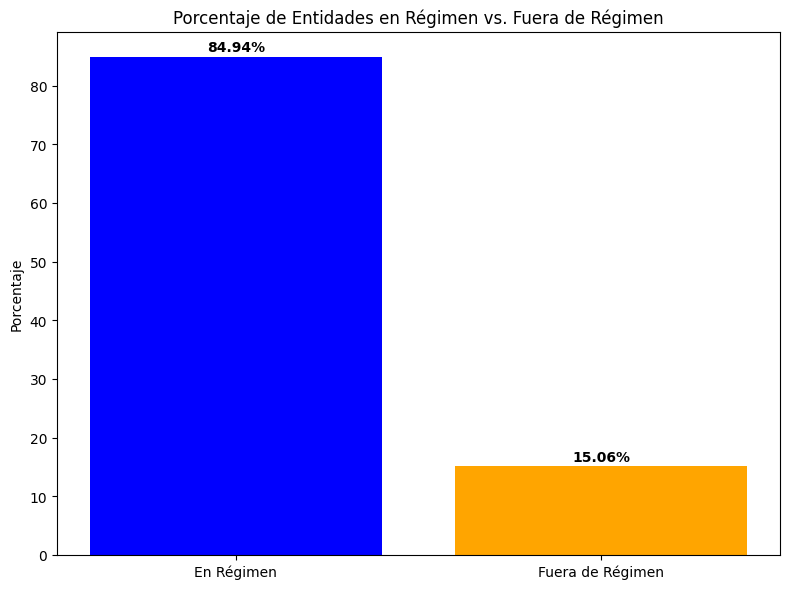

In [ ]:
# Calcular el porcentaje de entidades en régimen y fuera de régimen
porcentaje_en_regimen = (tg_itagui['RegimenHospital'].value_counts(normalize=True)[1]) * 100
porcentaje_fuera_regimen = (tg_itagui['RegimenHospital'].value_counts(normalize=True)[0]) * 100

# Crear el gráfico de comparación
fig, ax = plt.subplots(figsize=(8, 6))

# Gráfico de barras con porcentajes
ax.bar(['En Régimen', 'Fuera de Régimen'], [porcentaje_en_regimen, porcentaje_fuera_regimen], color=['blue', 'orange'])
ax.set_title('Porcentaje de Entidades en Régimen vs. Fuera de Régimen')
ax.set_ylabel('Porcentaje')

# Añadir etiquetas de porcentaje encima de cada barra
for i, v in enumerate([porcentaje_en_regimen, porcentaje_fuera_regimen]):
    ax.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()



Este análisis muestra que aproximadamente el 15.06% de los pacientes realizaron un traslado debido a diferencia de EPS, sin contar aquellos que tuvieron que ser trasladados por falta del servicio adecuado para su atención médica.

Ahora procedemos a hacer un analisis de la edad que mas requiere traslados

In [ ]:
# Convertimos la columna 'FECHA_NACIMIENTO' a formato de fecha para asegurarnos de que esté en el tipo de dato correcto
tg_itagui['FECHA_NACIMIENTO'] = pd.to_datetime(tg_itagui['FECHA_NACIMIENTO'], errors='coerce')

# Calculamos la edad en años restando el año actual con el año de la fecha de nacimiento, y la guardamos en una nueva columna llamada 'edad'
tg_itagui['edad'] = tg_itagui['FECHA_NACIMIENTO'].apply(lambda x: datetime.now().year - x.year if pd.notnull(x) else None)

# Revisamos las primeras filas del dataframe para asegurarnos de que la columna 'edad' se haya agregado correctamente
tg_itagui.head()

,TIPO,FECHA_NACIMIENTO,MUNICIPIO,SEXO,COD_DX,NOMBRE_DX,ENTIDAD,NivelHospital,RegimenHospital,edad
0,CC,1972-09-24,ITAGUI,F,D172,TUMOR BENIGNO LIPOMATOSO DE PIEL Y DE TEJIDO S...,PARTICULARES,2,0,52
1,CC,1981-01-29,SAN PEDRO,M,S523,FRACTURA DE LA DIAFISIS DEL RADIO,SEGUROS GENERALES SURAMERICANA,2,1,43
2,CC,1973-09-11,ITAGUI,F,S324,FRACTURA DEL ACETABULO,ADRES (ADMINISTRADORA DE LOS RECURSOS DEL SGSSS),2,0,51
3,RC,2018-04-07,ENVIGADO,F,J042,LARINGOTRAQUEITIS AGUDA,EPS SURA CONTRIBUTIVO 2020,2,1,6
4,CC,1994-01-03,MEDELLIN,F,S823,FRACTURA DE LA EPIFISIS INFERIOR DE LA TIBIA,ALIANZA MEDELLIN ANTIOQUIA SAS,2,1,30


El regimen hospital si el valor es 0 es por que no tiene vinculacion, si el valor es 1, es por que el hospital si tiene vinculacion. Se hace la grafica para ver segun la edad cual es el grupo que mas necesita traslados segun su falta de regimen

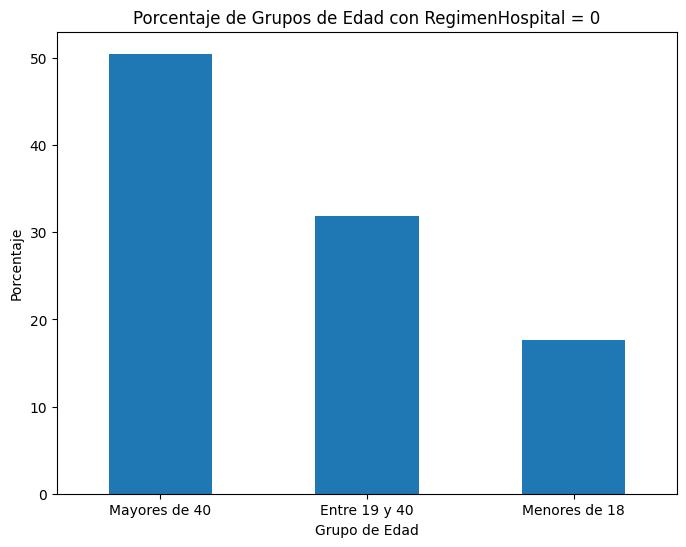

In [ ]:

# Filtramos el dataframe para quedarnos solo con los registros donde 'RegimenHospital' es igual a 0
tg_itagui_regimen_0 = tg_itagui[tg_itagui['RegimenHospital'] == 0]

# Definimos una función para clasificar cada edad en un grupo específico
def clasificar_grupo_edad(edad):
    if edad < 18:
        return 'Menores de 18'
    elif 19 <= edad <= 40:
        return 'Entre 19 y 40'
    else:
        return 'Mayores de 40'

# Aplicamos la función para crear una nueva columna que indica el grupo de edad
tg_itagui_regimen_0['GrupoEdad'] = tg_itagui_regimen_0['edad'].apply(clasificar_grupo_edad)

# Calculamos el porcentaje de cada grupo de edad con 'RegimenHospital' igual a 0
porcentaje_grupos = tg_itagui_regimen_0['GrupoEdad'].value_counts(normalize=True) * 100

# Generamos la gráfica de barras para visualizar mejor los porcentajes
plt.figure(figsize=(8, 6))
porcentaje_grupos.plot(kind='bar')
plt.title('Porcentaje de Grupos de Edad con RegimenHospital = 0')
plt.xlabel('Grupo de Edad')
plt.ylabel('Porcentaje')
plt.xticks(rotation=0)
plt.show()



In [ ]:
porcentaje_grupos

,proportion
GrupoEdad,
Mayores de 40,50.487805
Entre 19 y 40,31.918699
Menores de 18,17.593496


Dentro del grupo de pacientes que no tienen régimen con el hospital original y requieren traslados, el 50.49% corresponde a mayores de 40 años, seguidos por un 31.92% de personas entre 19 y 40 años, y un 17.59% de menores de 18. Esto indica que la falta de cobertura de la EPS afecta principalmente a los adultos mayores, quienes requieren traslados con mayor frecuencia

# DATASET DE PASTO

El dataset del hospital de pasto, corresponde al hospital: Empresa Social del Estado Pasto Salud que es de nivel, que corresponde a la mayoria de hospital de las regiones rurales del pais.
[Dataset pasto](https://www.datos.gov.co/Salud-y-Protecci-n-Social/Remisiones-de-pacientes/emmz-uf6m/about_data)



In [ ]:
# URL del archivo .csv en GitHub
url_csv1 = 'https://raw.githubusercontent.com/aisaza609/Datos_a_la_U_grupo_2/refs/heads/main/Dataset%20de%20datos%20abiertos/Remisiones_de_pacientes_pasto.csv'

# Descargar y cargar el archivo .csv
response_csv = requests.get(url_csv1)
if response_csv.status_code == 200:
    df_pasto = pd.read_csv(BytesIO(response_csv.content))
    df_pasto.head()
else:
    print("No se pudo descargar el archivo .csv.")
df_pasto.head()


,IPS,FechaAsignacionRegistro,Sexo,Edad,Hora_Salida,Objeto_Remision,Impresiones_Diagnosticas
0,CS LORENZO,01/07/2020 11:20:00 AM,M,70,11:15,OTRO,Diagnóstico Pincipal: K069 - TRASTORNO NO ESPE...
1,CS OBONUCO,01/07/2020 11:22:00 AM,M,24,11:16,OTRO,Diagnóstico Pincipal: K047 - ABSCESO PERIAPICA...
2,CS ENCANO,01/07/2020 11:25:00 AM,F,37,11:24,MEDICINA INTERNA,Diagnóstico Pincipal: I443 - OTROS TIPOS DE BL...
3,CS TAMASAGRA,01/07/2020 11:28:00 AM,F,3,11:26,PEDIATRIA,Diagnóstico Pincipal: E45X - RETARDO DEL DESAR...
4,CS TAMASAGRA,01/07/2020 11:31:00 AM,M,55,11:28,ORTOPEDIA,Diagnóstico Pincipal: M751 - SINDROME DE MANGUITO


## Procesamiento de Datos

Procesamos los datos revisando la existencia de valores nulos, datos incompletos y la relevancia de cada variable en el modelo descriptivo. Nuestro objetivo es identificar las especialidades en las que se requirieron remisiones a un nivel superior, debido a la imposibilidad de atenderlas en el nivel actual.

In [ ]:
print(" \nDataset shape (rows, cols): \n\n",
      df_pasto.shape)
print(" \nCount total NaN at each column in the dataset : \n\n",
      df_pasto.isnull().sum())

 
Dataset shape (rows, cols): 

 (30172, 7)
 
Count total NaN at each column in the dataset : 

 IPS                         0
FechaAsignacionRegistro     0
Sexo                        0
Edad                        0
Hora_Salida                 0
Objeto_Remision             0
Impresiones_Diagnosticas    0
dtype: int64


In [ ]:
df_pasto.columns.tolist() #mostramos los nombres de las columnas

['IPS',
 'FechaAsignacionRegistro',
 'Sexo',
 'Edad',
 'Hora_Salida',
 'Objeto_Remision',
 'Impresiones_Diagnosticas']

In [ ]:
df_pasto.Objeto_Remision.value_counts() #mostramos la informacion de las columnas

,count
Objeto_Remision,
OTRO,5638
OPTOMETRIA,4810
GINECOLOGIA,2376
NUTRICION,2362
ORTOPEDIA,2002
MEDICINA INTERNA,1862
OFTALMOLOGIA,1652
PEDIATRIA,1512
CIRUGIA GENERAL,1330


In [ ]:
# Definir un diccionario de mapeo para simplificar valores similares
mapeo_objeto_remision = {
    "POMEROY": "POMEROY",
    "REALIZACION DE POMEROY": "POMEROY",
    "RELIZACION DE POMEROY": "POMEROY",
    "RELIZACION POMEROY": "POMEROY",
}

# Función para reemplazar los valores basados en el diccionario
def simplificar_objeto_remision(objeto):
    return mapeo_objeto_remision.get(objeto, objeto)  # Devuelve el valor mapeado si existe, sino el original

# Aplicar la función a la columna 'Objeto_Remision'
df_pasto['Objeto_Remision'] = df_pasto['Objeto_Remision'].apply(simplificar_objeto_remision)

# Verificar los cambios realizados
print(df_pasto['Objeto_Remision'].value_counts())


Objeto_Remision
OTRO                               5638
OPTOMETRIA                         4810
GINECOLOGIA                        2376
NUTRICION                          2362
ORTOPEDIA                          2002
MEDICINA INTERNA                   1862
OFTALMOLOGIA                       1652
PEDIATRIA                          1512
CIRUGIA GENERAL                    1330
DERMATOLOGIA                        974
OTORRINOLARINGOLOGIA                894
PSIQUIATRIA                         674
NEUROCIRUGIA                        642
UROLOGIA                            608
NEUROLOGIA                          484
NEFROLOGIA                          448
GASTROENTEROLOGIA                   370
FISIATRIA                           334
PSICOLOGIA                          212
NEUROPSICOLOGIA                     210
TERAPIA FISICA Y REHABILITACION     204
CIRUGIA VASCULAR                    124
REUMATOLOGIA                         94
NEUROPEDIATRIA                       78
CARDIOLOGIA             

Para el analisis de este dataset vamos a observar que remisiones de servicios que requirieron traslados ya que son servicios que el hospital no cuenta, para eso nos vamos del dataset de prestadores REPS, para saber el nivel de antencion y los servicios prestados.[REPS](https://prestadores.minsalud.gov.co/habilitacion/consultas/habilitados_reps.aspx?pageTitle=Registro%20Actual&pageHlp=)

In [ ]:
# Agregar una nueva columna 'NivelHospital' con el valor 1 en todo el dataset
df_pasto['NivelHospital'] = 1

# Mostrar las primeras filas para verificar la nueva columna
df_pasto



,IPS,FechaAsignacionRegistro,Sexo,Edad,Hora_Salida,Objeto_Remision,Impresiones_Diagnosticas,NivelHospital
0,CS LORENZO,01/07/2020 11:20:00 AM,M,70,11:15,OTRO,Diagnóstico Pincipal: K069 - TRASTORNO NO ESPE...,1
1,CS OBONUCO,01/07/2020 11:22:00 AM,M,24,11:16,OTRO,Diagnóstico Pincipal: K047 - ABSCESO PERIAPICA...,1
2,CS ENCANO,01/07/2020 11:25:00 AM,F,37,11:24,MEDICINA INTERNA,Diagnóstico Pincipal: I443 - OTROS TIPOS DE BL...,1
3,CS TAMASAGRA,01/07/2020 11:28:00 AM,F,3,11:26,PEDIATRIA,Diagnóstico Pincipal: E45X - RETARDO DEL DESAR...,1
4,CS TAMASAGRA,01/07/2020 11:31:00 AM,M,55,11:28,ORTOPEDIA,Diagnóstico Pincipal: M751 - SINDROME DE MANGUITO,1
...,...,...,...,...,...,...,...,...
30167,CS OBONUCO,01/20/2020 10:41:00 AM,F,53,10:40,MEDICINA INTERNA,Diagnóstico Pincipal: E119 - DIABETES MELLITUS NO,1
30168,CS OBONUCO,01/20/2020 10:43:00 AM,F,53,10:41,OFTALMOLOGIA,Diagnóstico Pincipal: E119 - DIABETES MELLITUS NO,1
30169,CS SAN VICENTE,01/20/2020 10:43:00 AM,M,22,10:41,DERMATOLOGIA,Diagnóstico Pincipal: L910 - CICATRIZ QUELOIDE ;,1
30170,CS PROGRESO,01/20/2020 10:44:00 AM,F,91,10:42,NEFROLOGIA,Diagnóstico Pincipal: N189 - INSUFICIENCIA REN...,1


El diccionario de especialidades médicas se clasifica en tres niveles de atención:
1.  Nivel 1: Especialidades básicas de atención primaria, como medicina general y pediatría, que no requieren tecnología avanzada.
2.  Nivel 2: Especialidades de complejidad intermedia, como cardiología y ortopedia, que pueden necesitar algunos equipos especializados.
3. Nivel 3: Especialidades de alta complejidad, como neurocirugía y oncología, que requieren instalaciones avanzadas y equipos altamente especializados.







In [ ]:
# Definir el mapeo de especialidades a niveles de atención con términos clave
nivel_atencion_map = {
    "nivel 1": ["medicina general", "nutricion", "optometria", "psicologia", "terapia fisica", "rehabilitacion"],
    "nivel 2": ["medicina interna", "cirugia general", "ortopedia", "ginecologia", "pediatria", "urologia", "psiquiatria", "alergologia","pomeroy","vasectomia"],
    "nivel 3": ["cardiologia", "cirugia plastica", "cirugia vascular", "dermatologia", "endocrinologia", "fisiatria",
                "gastroenterologia", "genetica", "hematologia", "nefrologia", "neumologia", "neurocirugia",
                "neurologia", "neuropediatria", "oftalmologia", "oncologia", "otorrinolaringologia", "reumatologia"]
}

# Función para asignar el nivel de atención según el objeto de remisión
def asignar_nivel_atencion(objeto_remision):
    objeto_remision_lower = str(objeto_remision).lower()  # Convertir a minúsculas para comparación
    for nivel, especialidades in nivel_atencion_map.items():
        # Verificamos si alguna palabra clave de la especialidad está en el objeto de remisión
        if any(especialidad in objeto_remision_lower for especialidad in especialidades):
            return int(nivel.split()[-1])  # Devolver solo el número de nivel
    return None  # Si no se encuentra, devolver None

# Aplicar la función para crear la columna 'NiveldeAtencionNecesario'
df_pasto['NiveldeAtencionNecesario'] = df_pasto['Objeto_Remision'].apply(asignar_nivel_atencion)

# Guardar el dataset actualizado
df_pasto.to_csv('Remisiones_de_pacientes_pasto_con_nivel.csv', index=False)

# Mostrar el conteo de niveles asignados para verificar
print(df_pasto['NiveldeAtencionNecesario'].value_counts())




NiveldeAtencionNecesario
2.0    10950
1.0     7798
3.0     5786
Name: count, dtype: int64


In [ ]:
print(" \nDataset shape (rows, cols): \n\n",
      df_pasto.shape)
print(" \nCount total NaN at each column in the dataset : \n\n",
      df_pasto.isnull().sum())

 
Dataset shape (rows, cols): 

 (30172, 9)
 
Count total NaN at each column in the dataset : 

 IPS                            0
FechaAsignacionRegistro        0
Sexo                           0
Edad                           0
Hora_Salida                    0
Objeto_Remision                0
Impresiones_Diagnosticas       0
NivelHospital                  0
NiveldeAtencionNecesario    5638
dtype: int64


In [ ]:
df_pasto.NiveldeAtencionNecesario.value_counts() #mostramos la informacion de las columnas

,count
NiveldeAtencionNecesario,
2.0,10950
1.0,7798
3.0,5786


## Analisis de los datos

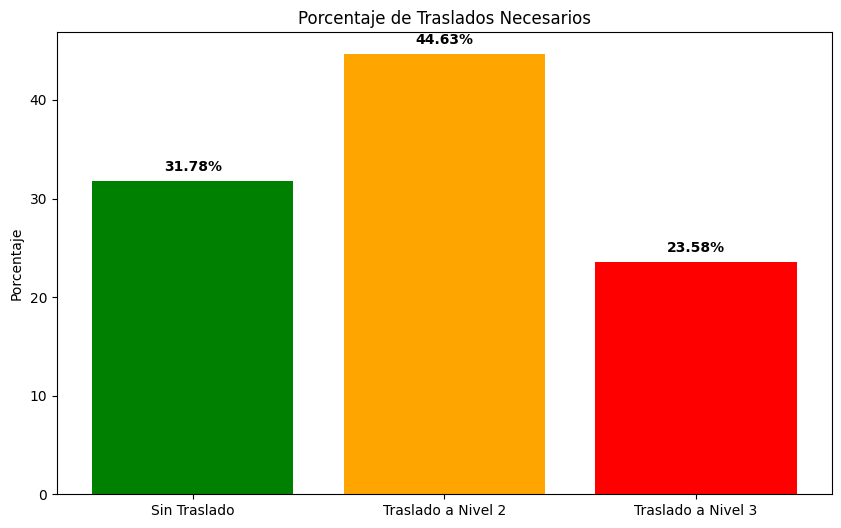

Porcentaje sin traslado: 31.784462378739708
Porcentaje traslado a nivel 2: 44.631939349474195
Porcentaje traslado a nivel 3: 23.583598271786094


In [ ]:
import matplotlib.pyplot as plt

# Definir el nivel del hospital
nivel_hospital = 1

# Crear la columna 'Traslado' con la lógica actualizada
def definir_traslado(nivel_necesario):
    if nivel_necesario == nivel_hospital:
        return 0  # No se necesita traslado
    elif nivel_necesario == 2:
        return 1  # Traslado a un hospital de nivel 2
    elif nivel_necesario == 3:
        return 2  # Traslado a un hospital de nivel 3
    return None  # Para casos donde el nivel no esté definido

# Aplicar la función para crear la columna 'Traslado'
df_pasto['Traslado'] = df_pasto['NiveldeAtencionNecesario'].apply(definir_traslado)

# Calcular los porcentajes de cada tipo de traslado
porcentaje_no_traslado = (df_pasto['Traslado'].value_counts(normalize=True)[0]) * 100
porcentaje_traslado_nivel_2 = (df_pasto['Traslado'].value_counts(normalize=True).get(1, 0)) * 100
porcentaje_traslado_nivel_3 = (df_pasto['Traslado'].value_counts(normalize=True).get(2, 0)) * 100

# Crear un DataFrame de comparación para visualización
comparacion_traslado = pd.DataFrame({
    'Categoria': ['Sin Traslado', 'Traslado a Nivel 2', 'Traslado a Nivel 3'],
    'Porcentaje': [porcentaje_no_traslado, porcentaje_traslado_nivel_2, porcentaje_traslado_nivel_3]
})

# Gráfico de comparación de porcentajes de traslado
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(comparacion_traslado['Categoria'], comparacion_traslado['Porcentaje'], color=['green', 'orange', 'red'])
ax.set_title('Porcentaje de Traslados Necesarios')
ax.set_ylabel('Porcentaje')

# Añadir etiquetas de porcentaje encima de cada barra
for i, v in enumerate(comparacion_traslado['Porcentaje']):
    ax.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.show()

# Verificar la nueva columna y el porcentaje de traslados
print("Porcentaje sin traslado:", porcentaje_no_traslado)
print("Porcentaje traslado a nivel 2:", porcentaje_traslado_nivel_2)
print("Porcentaje traslado a nivel 3:", porcentaje_traslado_nivel_3)


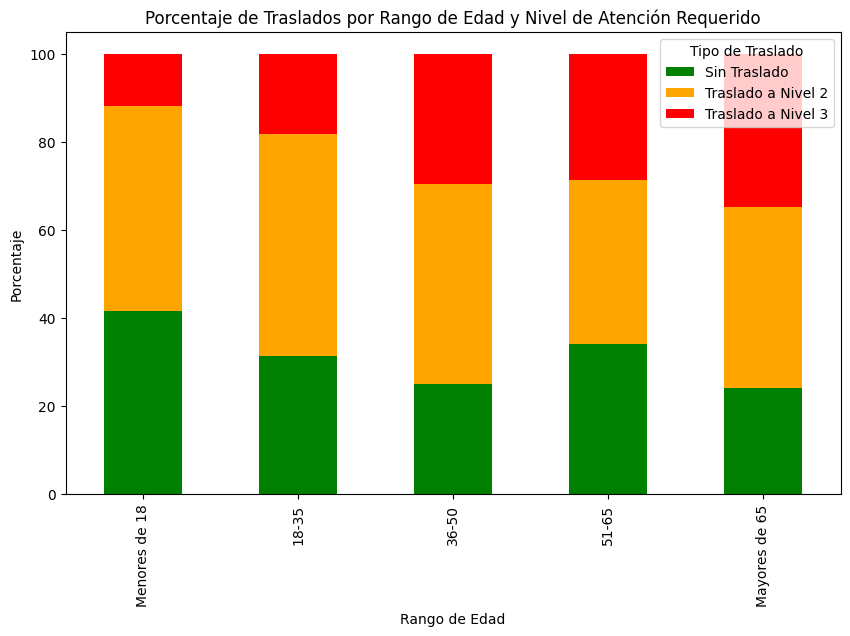

In [ ]:
# Definimos los rangos de edad en función de la columna 'Edad'
df_pasto['RangoEdad'] = pd.cut(df_pasto['Edad'], bins=[0, 17, 35, 50, 65, 100],
                               labels=['Menores de 18', '18-35', '36-50', '51-65', 'Mayores de 65'])

# Agrupamos por rango de edad y tipo de traslado para calcular el porcentaje en cada categoría
traslados_por_edad = df_pasto.groupby(['RangoEdad', 'Traslado']).size().unstack(fill_value=0)
traslados_por_edad = traslados_por_edad.div(traslados_por_edad.sum(axis=1), axis=0) * 100

# Generamos el gráfico de barras apiladas para visualizar los porcentajes de traslados por rango de edad
traslados_por_edad.plot(kind='bar', stacked=True, color=['green', 'orange', 'red'], figsize=(10, 6))
plt.title('Porcentaje de Traslados por Rango de Edad y Nivel de Atención Requerido')
plt.xlabel('Rango de Edad')
plt.ylabel('Porcentaje')
plt.legend(['Sin Traslado', 'Traslado a Nivel 2', 'Traslado a Nivel 3'], title='Tipo de Traslado')
plt.show()



In [ ]:
# Calcular los porcentajes totales de cada tipo de traslado en el dataset completo para verificar la distribución general
traslado_counts = df_pasto['Traslado'].value_counts(normalize=True) * 100

# Verificar la cantidad de cada tipo de traslado (sin traslado, traslado a nivel 2, traslado a nivel 3) en porcentaje
porcentaje_sin_traslado = traslado_counts.get(0, 0)  # Porcentaje de sin traslado
porcentaje_traslado_nivel_2 = traslado_counts.get(1, 0)  # Porcentaje de traslado a nivel 2
porcentaje_traslado_nivel_3 = traslado_counts.get(2, 0)  # Porcentaje de traslado a nivel 3

porcentaje_sin_traslado, porcentaje_traslado_nivel_2, porcentaje_traslado_nivel_3


(31.784462378739708, 44.631939349474195, 23.583598271786094)

In [ ]:
# Crear una nueva columna 'RangoEdad' con los grupos de edad especificados
# 1: Menor de 18 años, 2: Entre 19 y 45 años, 3: 45 años en adelante

df_pasto['RangoEdad'] = pd.cut(df_pasto['Edad'], bins=[0, 18, 45, 100], labels=[1, 2, 3], right=False)

# Verificar la nueva columna para asegurarnos de que se creó correctamente
df_pasto[['Edad', 'RangoEdad']].head(10)


,Edad,RangoEdad
0,70,3
1,24,2
2,37,2
3,3,1
4,55,3
5,10,1
6,91,3
7,52,3
8,30,2
9,45,3


In [ ]:
df_pasto.RangoEdad.value_counts() #mostramos la informacion de las columnas

,count
RangoEdad,
3,13408
2,10590
1,6174


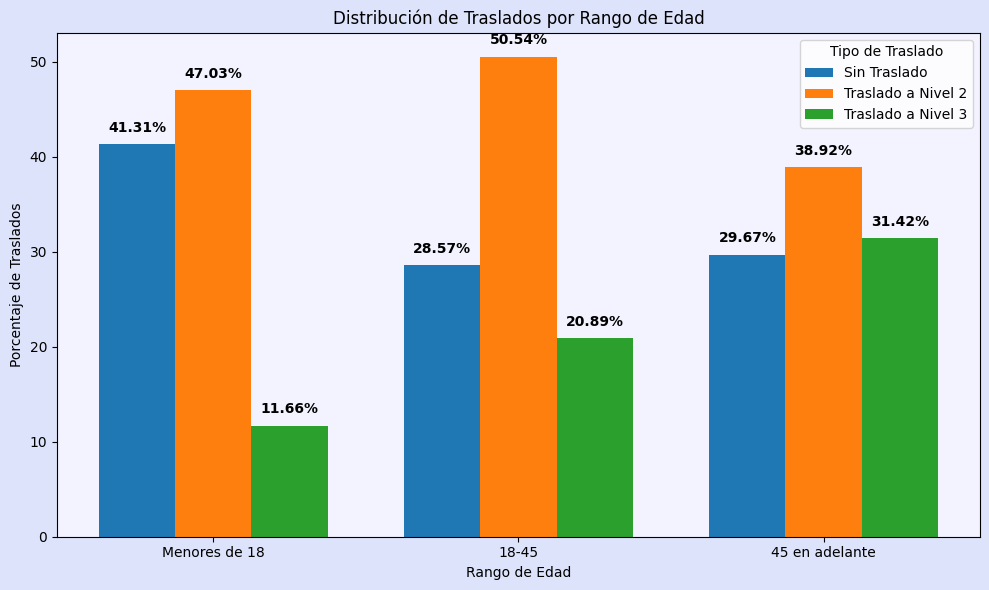

In [ ]:

# Calcular el porcentaje de cada tipo de traslado dentro de cada rango de edad
traslados_por_rango = df_pasto.groupby(['RangoEdad', 'Traslado']).size().unstack(fill_value=0)
traslados_por_rango = traslados_por_rango.div(traslados_por_rango.sum(axis=1), axis=0) * 100

# Configuración de las etiquetas y los colores
categorias = ['Sin Traslado', 'Traslado a Nivel 2', 'Traslado a Nivel 3']
bar_width = 0.25
index = np.arange(len(traslados_por_rango))

fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras para cada tipo de traslado en cada rango de edad
for i, categoria in enumerate(categorias):
    barras = plt.bar(index + i * bar_width, traslados_por_rango[i], bar_width, label=categoria)

    # Agregar etiquetas de porcentaje encima de cada barra
    for bar in barras:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom', fontweight='bold')

# Configurar etiquetas y diseño
ax.set_xlabel('Rango de Edad')
ax.set_ylabel('Porcentaje de Traslados')
ax.set_title('Distribución de Traslados por Rango de Edad')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(['Menores de 18', '18-45', '45 en adelante'])
ax.legend(title="Tipo de Traslado")

# Ajustar el diseño de fondo
fig.patch.set_facecolor('#DDE3FA')
ax.set_facecolor('#F3F3FF')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


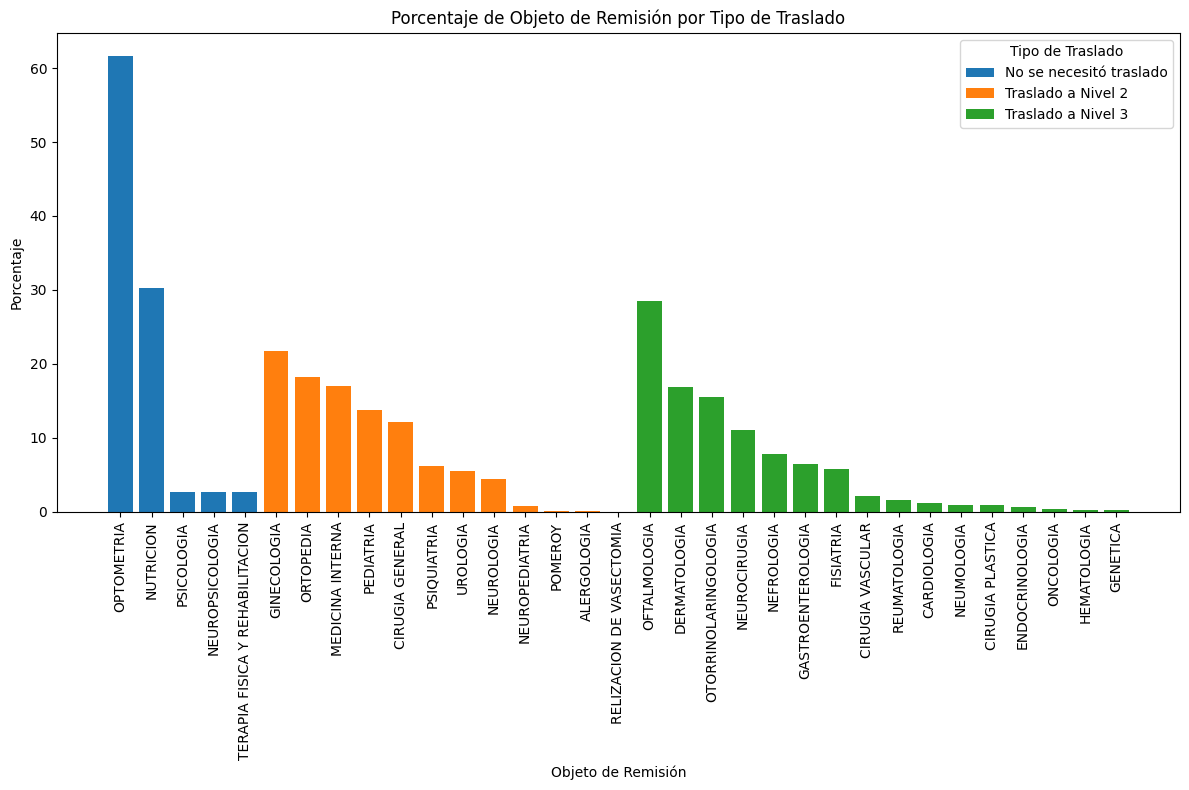

In [ ]:
# Crear un diccionario de mapeo para reemplazar valores numéricos en la columna 'Traslado'
mapeo_traslado = {
    0: "No se necesitó traslado",
    1: "Traslado a Nivel 2",
    2: "Traslado a Nivel 3"
}

# Aplicar el mapeo a la columna 'Traslado'
df_pasto['Traslado'] = df_pasto['Traslado'].map(mapeo_traslado)

# Volver a calcular el conteo y el porcentaje de cada tipo de traslado
conteo_objeto_remision_por_traslado = df_pasto.groupby(['Traslado', 'Objeto_Remision']).size().reset_index(name='Conteo')
total_por_traslado = df_pasto['Traslado'].value_counts().reset_index()
total_por_traslado.columns = ['Traslado', 'Total']
resultado = pd.merge(conteo_objeto_remision_por_traslado, total_por_traslado, on='Traslado')
resultado['Porcentaje'] = (resultado['Conteo'] / resultado['Total']) * 100
resultado = resultado[['Traslado', 'Objeto_Remision', 'Conteo', 'Total', 'Porcentaje']]
resultado = resultado.sort_values(by=['Traslado', 'Porcentaje'], ascending=[True, False])

# Graficar usando las etiquetas descriptivas en la leyenda
fig, ax = plt.subplots(figsize=(12, 8))
for traslado in resultado['Traslado'].unique():
    subset = resultado[resultado['Traslado'] == traslado]
    ax.bar(subset['Objeto_Remision'], subset['Porcentaje'], label=traslado)

ax.set_title('Porcentaje de Objeto de Remisión por Tipo de Traslado')
ax.set_ylabel('Porcentaje')
ax.set_xlabel('Objeto de Remisión')
ax.legend(title='Tipo de Traslado')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [ ]:
resultado

,Traslado,Objeto_Remision,Conteo,Total,Porcentaje
2,No se necesitó traslado,OPTOMETRIA,4810,7798,61.682483
1,No se necesitó traslado,NUTRICION,2362,7798,30.289818
3,No se necesitó traslado,PSICOLOGIA,212,7798,2.718646
0,No se necesitó traslado,NEUROPSICOLOGIA,210,7798,2.692998
4,No se necesitó traslado,TERAPIA FISICA Y REHABILITACION,204,7798,2.616055
7,Traslado a Nivel 2,GINECOLOGIA,2376,10950,21.698630
11,Traslado a Nivel 2,ORTOPEDIA,2002,10950,18.283105
8,Traslado a Nivel 2,MEDICINA INTERNA,1862,10950,17.004566
12,Traslado a Nivel 2,PEDIATRIA,1512,10950,13.808219
6,Traslado a Nivel 2,CIRUGIA GENERAL,1330,10950,12.146119


1. No se necesitó traslado:

Las especialidades con mayor porcentaje en esta categoría son Optometría y Nutrición, con alrededor de un 60% y 35% respectivamente.
Esto sugiere que, para estos servicios, la atención pudo realizarse en el hospital actual sin necesidad de trasladar a los pacientes.

2. Traslado a Nivel 2:
En los traslados al Nivel 2, las especialidades más demandadas son Ginecología, Ortopedia, Medicina Interna y Pediatría, con porcentajes que rondan entre el 10% y el 20%.
Esto indica que estos servicios especializados requieren infraestructura o experiencia que está disponible en hospitales de Nivel 2, pero no en el hospital de Nivel 1.

3. Traslado a Nivel 3:
Los traslados a Nivel 3 muestran un alto porcentaje en Oftalmología, seguido de Dermatología y Otorrinolaringología.
Este patrón sugiere que estas especialidades requieren tecnología avanzada o especialistas de alta cualificación que solo se encuentran en hospitales de Nivel 3.

4. Conclusiones generales:
Las especialidades que no requieren traslado están relacionadas principalmente con servicios de consulta externa y rehabilitación.
Los traslados al Nivel 2 son frecuentes en especialidades comunes en atención especializada, como ginecología y pediatría, que requieren algunos equipos avanzados y especialistas, pero no de alta complejidad.
Los traslados al Nivel 3 están asociados con especialidades que suelen requerir equipamiento de alta tecnología y subespecialistas, lo cual justifica la necesidad de un hospital de mayor nivel.

In [ ]:
# Exportar el DataFrame a Excel
df_pasto.to_excel('Hospital_Pasto_v1.xlsx', index=False, engine='openpyxl')

